# Homework 5

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Section 1: Smart-Beta ETFs

*This section will not be graded, but it will be discussed in class.*

**Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

1. Describe how each of the factors (other than MKT) is measured. That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

<span style="color:red;">

Each of the portfolios is constructed using "decile" portfolios given by the relevant factor. So, the portfolio will only be concerned with the top and/or bottom decile of firms as measured by...

* **Size (SMB):** Market Capitalization.

* **Value (HML):** Book-to-Market Ratio

* **Profitability (RMW):** Operating Profit to Book Value.

* **Investment (CMA):** Percentage change in a firm's assets (balance sheet).

* **Momentum (UMD):** Recent stock price returns.

</span>

2. Is the factor portfolio...
* long-only
* long-short
* value-weighted
* equally-weighted

<span style="color:red;">

The Fama-French factor portfolios are long-short portfolios where one goes long the top decile of stocks measured by a given factor, and short the bottom decile. The Market portfolio, however, is always value-weighted. One can also construct these factors using long-only portfolios where you include only the top decile or quartile.

</span>

4. What steps are taken in the factor construction to try to reduce the correlation between the factors?

<span style="color:red;">

Well the factors are chosen to be meaningfully different from one another. In this way, one would expect the cross-section of firms that fall in the top- and bottom-deciles should be meaningfully different across factors. Additionally, to reduce correlation with market returns, the portfolios under the Fama-French approach are constructed on a long-short basis. In this way, their returns not only move with firms that are positive representatives of the factor, but also move inversely with firms that are negative representations of the factor. In this way, the portfolios' returns are more aggressively driven by the factors and more likely to be near-orthogonal to one another.

</span>

5. What is the point of figures 1-6?

<span style="color:red;">

The are meant to give a visual representation of the relationships between returns and the various factors.

</span>

6. How is a “smart beta” ETF different from a traditional ETF?

<span style="color:red;">

A "smart beta" ETF is different from a traditional ETF in that it is "quasi-active." By "quasi-active," I mean that the allocations in the portfolio are not simply driven by market-value weightings, but some more sophisticated methodology. Traditional ETFs, on the other hand, are typically passive with strict market-value weightings.

</span>

7. Is it possible for all investors to have exposure to the “value” factor?

<span style="color:red;">

No, as the great Cliff Asness is quoted saying in this case, "A portfolio that deviates from market weights... must be balanced by other investors who are willing to take the other side of those bets. For example, for every value investor, who tilts toward or selects cheap value stocks, there must be an investor on the other side who is underweighting value and overweighting expensive, growth stocks. Hence, as everything must add up in the market-weighted portfolio, everyone at once cannot hold or tilt toward value at the same time."

</span>

8. How does factor investing differ from traditional diversification?

<span style="color:red;">

Quote from the case: "The intuition behind factor investing is that a standard diversification strategy that emphasizes asset classes may not have the optimal exposures to the factors that are known to yield high average returns across time. Moreover, since diversification is also about the correlation structure accross investments, factor investing can help maximize diversification by providing a richer set of cross-correlations and thereby better manage the risk and return of a portfolio across market cycles."

</span>

<span style="color:yellow;">

This point on diversification is, however, a bit misguided. These Smart Beta ETFs can provide "diversification" when they are the only elements in the portfolio, but they do not necessarily provide diversification in everyday market portfolios. They can, however, be leveraged to manage exposures to certain factors, but this strategy is different in spirit than pure diversification.

</span>

If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

# Imports

In [1]:
import os
import sys
import pandas as pd
from scipy.stats import norm, chi2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
sys.path.insert(0, parent_dir)
sys.path.insert(0, grandparent_dir)
import cmds.portfolio_management_helper as pmh

plt.style.use("seaborn-v0_8-whitegrid")
PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.4f}".format
p = plt.rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 2. The Factors

Use the data found in `factor_pricing_data.xlsx`.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.
* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
* The sheet also contains data on five additional factors.
* All factor data is already provided as excess returns

In [2]:
data_path = parent_dir + '/data/'
rf_rate = pmh.read_excel_default(data_path + 'factor_pricing_data.xlsx', 
                                 sheet_name='risk-free rate',
                                 index_col='Date', parse_dates=True)
factors = pmh.read_excel_default(data_path + 'factor_pricing_data.xlsx', 
                                 sheet_name='factors (excess returns)',
                                 index_col='Date', parse_dates=True)
portfolios = pmh.read_excel_default(data_path + 'factor_pricing_data.xlsx', 
                                 sheet_name='portfolios (excess returns)',
                                 index_col='Date', parse_dates=True)

In [3]:
display(factors.head(3))
display(portfolios.head(3))

,MKT,SMB,HML,RMW,CMA,UMD
date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0076,0.0285,0.0084,0.1009,-0.0143,0.1002,0.0362,0.0323,0.0048,0.0059,...,0.0158,0.0875,0.0465,-0.0126,0.0430,-0.0283,0.0258,0.0768,0.0308,0.0669
1980-02-29,0.0105,-0.0608,-0.0966,-0.0322,-0.0569,-0.0323,-0.0521,-0.0800,-0.0555,-0.0167,...,-0.0079,-0.0541,-0.0346,-0.0639,-0.0652,-0.0854,-0.0959,-0.0347,-0.0282,-0.0274
1980-03-31,-0.2224,-0.1119,-0.0167,-0.1469,-0.0193,-0.1271,-0.0826,-0.1237,-0.0566,-0.0668,...,-0.0819,-0.1509,-0.1098,-0.0906,-0.1449,-0.0560,-0.0880,-0.2451,-0.1254,-0.1726


1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so let’s compare there univariate statistics. • mean
• volatility
• Sharpe

In [4]:
pmh.calc_summary_statistics(factors, annual_factor=12, provided_excess_returns=True, 
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Min', 'Max',
                                          'Skewness', 'Excess Kurtosis', 'Annualized VaR', 'Annualized CVaR', 
                                          'Max Drawdown', 'Duration']).T

,MKT,SMB,HML,RMW,CMA,UMD
Annualized Mean,0.0863,0.0083,0.0258,0.0471,0.0295,0.0627
Annualized Vol,0.1569,0.1019,0.1100,0.0832,0.0731,0.1546
Annualized Sharpe,0.5499,0.0817,0.2346,0.5660,0.4041,0.4057
Min,-0.2324,-0.1532,-0.1388,-0.1865,-0.0720,-0.3430
Max,0.1365,0.1828,0.1280,0.1307,0.0907,0.1820
Skewness,-0.6653,0.3524,0.1298,-0.3736,0.3193,-1.3344
Excess Kurtosis,1.9957,3.8742,2.1014,10.7539,1.5804,9.9565
Max Drawdown,-0.5436,-0.5609,-0.5841,-0.4121,-0.2525,-0.5764
Duration (days),1433.0000,2557.0000,NaN,518.0000,546.0000,NaN


2. Based on the factor statistics above, answer the following.
(a) Does each factor have a positive risk premium (positive expected excess return)? (b) How have the factors performed since the time of the case, (2015-present)?

<span style="color:red;">

(a) Yes, each of the factors have a positive risk premium, as given by their positive Annualized Means in the above table (data used to compute these values are excess returns).

</span>

In [5]:
print('(b)')
pmh.calc_summary_statistics(factors.loc['2015':], annual_factor=12, provided_excess_returns=True, 
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Min', 'Max',
                                          'Skewness', 'Excess Kurtosis', 'Annualized VaR', 'Annualized CVaR', 
                                          'Max Drawdown', 'Duration']).T

(b)


,MKT,SMB,HML,RMW,CMA,UMD
Annualized Mean,0.1166,-0.0195,-0.0179,0.0509,-0.0084,0.0211
Annualized Vol,0.1603,0.1045,0.1327,0.0733,0.0840,0.1408
Annualized Sharpe,0.7274,-0.1866,-0.1345,0.6939,-0.1001,0.1497
Min,-0.1339,-0.0824,-0.1388,-0.0479,-0.0720,-0.1602
Max,0.1365,0.0828,0.1280,0.0727,0.0774,0.0998
Skewness,-0.3482,0.3554,0.2203,0.5048,0.3959,-0.7278
Excess Kurtosis,0.7328,0.4466,1.8216,1.0075,1.2741,1.9107
Max Drawdown,-0.2545,-0.2770,-0.5140,-0.0969,-0.2198,-0.2566
Duration (days),517.0000,NaN,NaN,120.0000,NaN,NaN


<span style="color:red;">

As we can see in the summary table above, the Market, profitability, and Momentum factors have continued to provide excess return premium. Though, the momentum premium has degraded in more recent periods. All other factors--Size, Value, and Investment--have provided negative real returns since the start of the DFA case.

</span>

3. Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

The highest correlation (67.84%) is between CMA and HML
The lowest correlation (-41.41%) is between SMB and RMW


<Axes: >

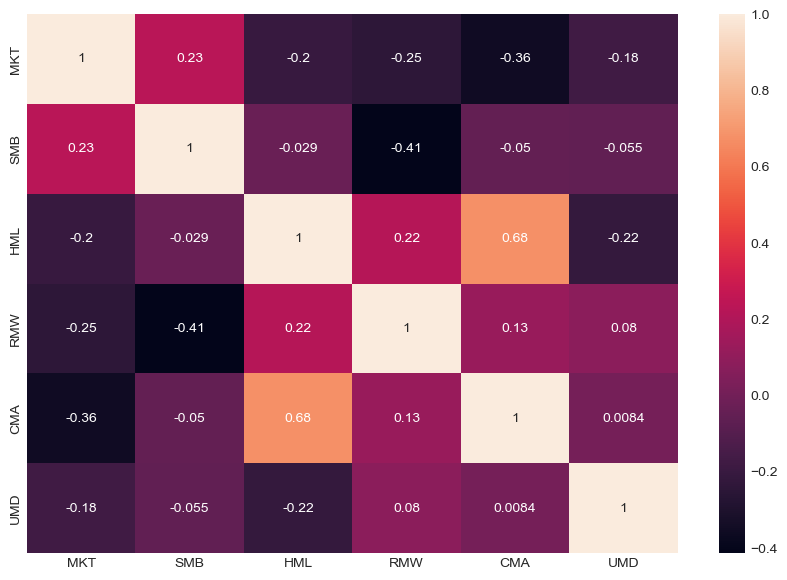

In [6]:
pmh.calc_correlations(factors)

<span style="color:red;">

The construction method does appear to succeed in keeping correlations (mostly) small. There only appears to be one exception to this success, which is the correlation between the Investment and Value factors, which stands relatively high at 67.84%. This exception seems to support Fama and French's contention that HML is somewhat redundant in their 5-factor model. 

</span>

The highest correlation (65.27%) is between CMA and HML
The lowest correlation (-42.96%) is between SMB and UMD


<Axes: >

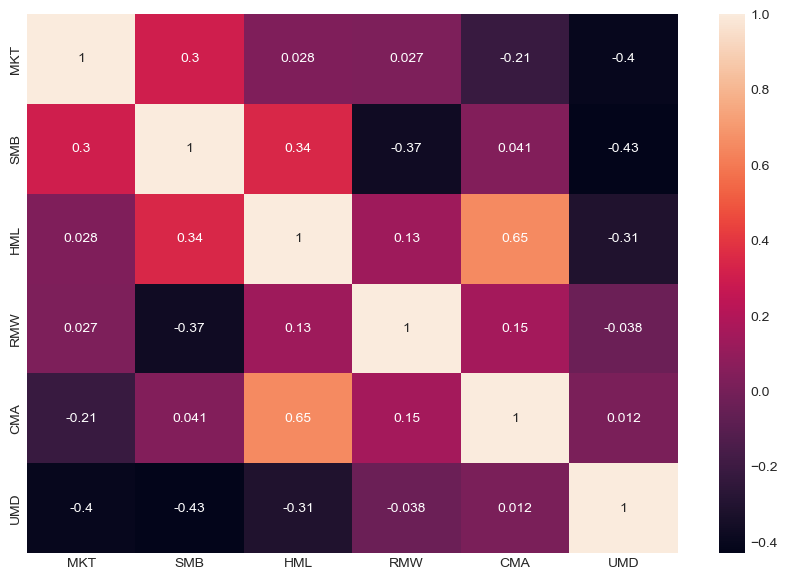

In [7]:
pmh.calc_correlations(factors['2015':])

<span style="color:red;">

Impressively, these correlations even hold up in the truncated recent period since the DFA case study took place. Consequently, the same conclusions as above seem to still hold true for more recent history.

</span>

4. Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [8]:
pd.concat([pmh.calc_tangency_weights(factors), pmh.calc_tangency_weights(factors['2015':], name='2015- Tangency Weights')], axis=1)

,Tangency Weights,2015- Tangency Weights Weights
MKT,0.2098,0.2844
SMB,0.0773,0.0454
HML,-0.0421,-0.0709
RMW,0.3133,0.4972
CMA,0.3390,0.0570
UMD,0.1028,0.1869


<span style="color:red;">

The most important factors appear to be the Investment and Profitability factors, which outweigh the Market factor in the tangency portfolio of these factors. Notably, all the returns except Value (HML) take on positive weights in this tangency portfolio and they all appear to be meaningfully different from 0, suggesting that even the factors with low mean returns are still useful. Also noteworthy is the apparent dropoff in importance of the Investment factor from the full analysis period to the more recent period since the DFA case study. The assets that seem to compensate for this decrease are the Market and Momentum factors.

</span>

What do you conclude about the importance or unimportance of these styles?

<span style="color:red;">

It appears that the Investment, Size, and Value factors have not been particularly important over the full horizon of this analysis and they have become even less important in recent periods. 

</span>

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

We are not saying this is “the” AQR model, but it is a good illustration of their most publicized factors: value, momentum, and more recently, profitability.

For instance, for the AQR model is...

![](../refs/LFP-4-factors.png)

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

![](../refs/LFD-4-factors.png)

Data
* PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . , 49.$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

<span style="color:red;">

**NOTE:** The numbers below are slightly incorrect. This seems to be a problem with the portfolio_management_helper.py code for the calc_cross_section_regression. This function is using the fitted means from the time series regressions instead of the mean returns from the raw time series data. 

Clarify computation with Mark and flag up any problems with Fernando.

</span>

1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)
* For each regression, report the estimated α and r-squared.
* Calculate the mean-absolute-error of the estimated alphas.
* If the pricing model worked, should these alpha estimates be large or small? Why?
* Based on your MAE stat, does this seem to support the pricing model or not?

In [9]:
AQR = ['MKT', 'HML', 'RMW', 'UMD']
aqr_ts_test = pmh.calc_iterative_regression(portfolios, factors[AQR], annual_factor=12,intercept=True, 
                                            keep_columns=['Annualized Alpha', 'R-Squared'])
display(aqr_ts_test)
print(f'Mean-Absolute-Error: {aqr_ts_test['Annualized Alpha'].abs().sum() / len(aqr_ts_test):.2%}\
      \nMin-Absolute-Error: {aqr_ts_test['Annualized Alpha'].abs().idxmin()} - {aqr_ts_test['Annualized Alpha'].abs().min():.2%}\
      \nMax-Absolute-Error: {aqr_ts_test['Annualized Alpha'].abs().idxmax()} - {aqr_ts_test['Annualized Alpha'].abs().max():.2%}')

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,Annualized Alpha,R-Squared
Agric,0.0077,0.3392
Food,0.0069,0.4642
Soda,0.0172,0.3084
Beer,0.0171,0.4208
Smoke,0.0353,0.2735
Toys,-0.0373,0.5083
Fun,0.0305,0.6165
Books,-0.0294,0.6868
Hshld,-0.0081,0.5584
Clths,-0.0182,0.6183


Mean-Absolute-Error: 2.30%      
Min-Absolute-Error: Rubbr - 0.05%      
Max-Absolute-Error: Softw - 6.65%


<span style="color:red;">

If the pricing model worked, then we would expect these alpha estimates to be quite small. The intuition behind this assertion is as follows--if the factors did a good job explaining the variation in the portfolios, then the $\alpha$'s would be zero since they **represent return that cannot be explained** by the factors. This is the same logic that underlies the CAPM model.

The MAE of this series of regressions seems to suggest that this set of factors doesn't do a great job of capturing returns across these portfolios because they, on average, miss out on about 2.3% of returns. Interestingly, this set of factors appears to do a fairly good job of capturing returns of equities in the **Rubber** industry, as it's $\alpha$ is a meager 0.05% while a considerable amount of equity returns in the **Software** industry are not well explained by these factors.

</span>

2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?

In [10]:
# CAPM Test
capm_ts_test = pmh.calc_iterative_regression(portfolios, factors['MKT'].to_frame(), annual_factor=12,intercept=True, 
                                            keep_columns=['Annualized Alpha', 'R-Squared'])
display(capm_ts_test)
print(f'Mean-Absolute-Error: {capm_ts_test['Annualized Alpha'].abs().sum() / len(capm_ts_test):.2%}\
      \nMin-Absolute-Error: {capm_ts_test['Annualized Alpha'].abs().idxmin()} - {capm_ts_test['Annualized Alpha'].abs().min():.2%}\
      \nMax-Absolute-Error: {capm_ts_test['Annualized Alpha'].abs().idxmax()} - {capm_ts_test['Annualized Alpha'].abs().max():.2%}\
      \nVariance of Errors: CAPM - {capm_ts_test['Annualized Alpha'].std():.2%}, AQR - {aqr_ts_test['Annualized Alpha'].std():.2%}')

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,Annualized Alpha,R-Squared
Agric,0.0203,0.3305
Food,0.0458,0.3665
Soda,0.0471,0.2537
Beer,0.0594,0.3337
Smoke,0.0812,0.1900
Toys,-0.0377,0.4954
Fun,0.0069,0.5993
Books,-0.0145,0.6523
Hshld,0.0212,0.4939
Clths,0.0005,0.5589


Mean-Absolute-Error: 2.04%      
Min-Absolute-Error: Banks - 0.01%      
Max-Absolute-Error: Smoke - 8.12%      
Variance of Errors: CAPM - 2.76%, AQR - 2.83%


<span style="color:red;">

Perhaps surprisingly, the CAPM model has a lower MAE than the AQR model and lower error volatility.

</span>

In [11]:
# Fama-French 3-Factor Test
FF3F = ['MKT', 'SMB', 'HML']
ff3f_ts_test = pmh.calc_iterative_regression(portfolios, factors[FF3F], annual_factor=12,intercept=True, 
                                            keep_columns=['Annualized Alpha', 'R-Squared'])
display(ff3f_ts_test)
print(f'Mean-Absolute-Error: {ff3f_ts_test['Annualized Alpha'].abs().sum() / len(ff3f_ts_test):.2%}\
      \nMin-Absolute-Error: {ff3f_ts_test['Annualized Alpha'].abs().idxmin()} - {ff3f_ts_test['Annualized Alpha'].abs().min():.2%}\
      \nMax-Absolute-Error: {ff3f_ts_test['Annualized Alpha'].abs().idxmax()} - {ff3f_ts_test['Annualized Alpha'].abs().max():.2%}')

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,Annualized Alpha,R-Squared
Agric,0.0161,0.3574
Food,0.0358,0.4167
Soda,0.0348,0.2805
Beer,0.0548,0.3624
Smoke,0.0661,0.2362
Toys,-0.0381,0.5287
Fun,0.0063,0.6098
Books,-0.0253,0.6888
Hshld,0.0179,0.5137
Clths,-0.0062,0.5744


Mean-Absolute-Error: 2.40%      
Min-Absolute-Error: BusSv - 0.03%      
Max-Absolute-Error: RlEst - 6.99%


<span style="color:red;">

The Fama-French 3-Factor model has greater MAE than the AQR model.

</span>

In [12]:
# Fama-French 5-Factor Test
FF5F = ['MKT', 'SMB', 'HML', 'RMW', 'CMA']
ff5f_ts_test = pmh.calc_iterative_regression(portfolios, factors[FF5F], annual_factor=12,intercept=True, 
                                            keep_columns=['Annualized Alpha', 'R-Squared'])
display(ff5f_ts_test)
print(f'Mean-Absolute-Error: {ff5f_ts_test['Annualized Alpha'].abs().sum() / len(ff5f_ts_test):.2%}\
      \nMin-Absolute-Error: {ff5f_ts_test['Annualized Alpha'].abs().idxmin()} - {ff5f_ts_test['Annualized Alpha'].abs().min():.2%}\
      \nMax-Absolute-Error: {ff5f_ts_test['Annualized Alpha'].abs().idxmax()} - {ff5f_ts_test['Annualized Alpha'].abs().max():.2%}')

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,Annualized Alpha,R-Squared
Agric,0.0003,0.3634
Food,-0.0026,0.4908
Soda,-0.0018,0.3132
Beer,0.0102,0.4424
Smoke,0.0110,0.3053
Toys,-0.0684,0.5497
Fun,0.0167,0.6137
Books,-0.0444,0.7028
Hshld,-0.0216,0.5893
Clths,-0.0406,0.6286


Mean-Absolute-Error: 3.14%      
Min-Absolute-Error: Agric - 0.03%      
Max-Absolute-Error: RlEst - 8.45%


<span style="color:red;">

Another surprise--the expanded Fama-French 5-factor model has greater MAE than the 3-factor model. Additionally, it has greater error than the AQR model. Harkening back to a point in question 2.3, this greater error may be driven by the relatively high correlation of the Value (HML) and Investment (CMA) factors.

</span>

3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

<span style="color:red;">

* Given that the CAPM had the lowest MAE across all four models, it appears that the market factor is especially important for pricing.

* Given that the AQR model has lower MAE than either of the Fama-French models, and its differentiating feature is the Momentum factor, it appears that the Momentum factor has greater explanatory power than some of the features in the Fama-French models. Consequently, it seems prudent for the Fama-French model to use the momentum factor.

However, a case can be made that adding the momentum factor the Fama-French model would actually introduce more noise that would then lead to greater error. We can test this directly.

</style>

In [13]:
TEST = FF5F + ['UMD']
test_ts_test = pmh.calc_iterative_regression(portfolios, factors[TEST], annual_factor=12,intercept=True, 
                                            keep_columns=['Annualized Alpha', 'R-Squared'])
print(f'\nMean-Absolute-Error: {test_ts_test['Annualized Alpha'].abs().sum() / len(test_ts_test):.2%}\
      \nMin-Absolute-Error: {test_ts_test['Annualized Alpha'].abs().idxmin()} - {test_ts_test['Annualized Alpha'].abs().min():.2%}\
      \nMax-Absolute-Error: {test_ts_test['Annualized Alpha'].abs().idxmax()} - {test_ts_test['Annualized Alpha'].abs().max():.2%}')

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios

Mean-Absolute-Error: 2.83%      
Min-Absolute-Error: Util  - 0.02%      
Max-Absolute-Error: Softw - 7.66%


<span style="color:red;">

This result shows that including momentum in the Fama-French model does actually reduce the MAE of the model for this universe of portfolios. In conclusion, my original assertion seems supported.

</span>

4. This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [14]:
ts_tests = {'CAPM': capm_ts_test['R-Squared'], 
            'AQR': aqr_ts_test['R-Squared'], 
            'FF3F': ff3f_ts_test['R-Squared'], 
            'FF5F': ff5f_ts_test['R-Squared']}
pd.DataFrame({'Avg R-Squared': [test.mean() for test in ts_tests.values()],
              'Max R-Squared': [test.max() for test in ts_tests.values()],
              'Min R-Squared': [test.min() for test in ts_tests.values()]}, index=ts_tests.keys()).style.format("{:.2%}")

,Avg R-Squared,Max R-Squared,Min R-Squared
CAPM,52.61%,84.43%,4.94%
AQR,57.49%,84.79%,5.00%
FF3F,57.15%,87.26%,5.53%
FF5F,59.60%,87.69%,6.93%


<span style="color:red;">

No, these models do not lead to high time-series $R^2$ stats. Consequently, these factors would not be very good for a Linear Factor Decomposition for many of the assets assessed here. There are some portfolios, however, where the $R^2$ is quite high and so these factors could do a fair job of replicating these portfolios.

However, we are not particularly concerned with $R^2$ stats when assessing Linear Pricing Models.

</span>

5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.
* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [15]:
time_series_regressions = pmh.calc_iterative_regression(portfolios, factors, annual_factor=12, warnings=False)
time_series_betas = time_series_regressions.filter(regex='Beta$', axis=1)
time_series_betas.mean().to_frame('TS Premia')

,TS Premia
MKT Beta,1.0318
SMB Beta,0.2599
HML Beta,0.0550
RMW Beta,0.2883
CMA Beta,0.1462
UMD Beta,-0.0744


In [16]:
capm_cs_test = pmh.calc_cross_section_regression(portfolios, factors['MKT'].to_frame(),provided_excess_returns=True, annual_factor=12, 
                                                 name='CAPM',keep_columns=['R-Squared', 'Annualized Eta', 'Annualized Lambda', 
                                                                           'TS Annualized MAE', 'CS Annualized MAE']).T
aqr_cs_test = pmh.calc_cross_section_regression(portfolios, factors[AQR],provided_excess_returns=True, annual_factor=12, 
                                                 name='AQR',keep_columns=['R-Squared', 'Annualized Eta', 'Annualized Lambda', 
                                                                           'TS Annualized MAE', 'CS Annualized MAE']).T
ff3f_cs_test = pmh.calc_cross_section_regression(portfolios, factors[FF3F],provided_excess_returns=True, annual_factor=12, 
                                                 name='FF3F',keep_columns=['R-Squared', 'Annualized Eta', 'Annualized Lambda', 
                                                                           'TS Annualized MAE', 'CS Annualized MAE']).T
ff5f_cs_test = pmh.calc_cross_section_regression(portfolios, factors[FF5F],provided_excess_returns=True, annual_factor=12, 
                                                 name='FF5F',keep_columns=['R-Squared', 'Annualized Eta', 'Annualized Lambda', 
                                                                           'TS Annualized MAE', 'CS Annualized MAE']).T
pd.concat([capm_cs_test, aqr_cs_test, ff3f_cs_test, ff5f_cs_test], axis=1)

Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns
Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns
Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns
Lambda represents the premium calculated by the cross-section regression and the historical premium is the average of the factor excess returns


,CAPM Cross-Section Regression,AQR Cross-Section Regression,FF3F Cross-Section Regression,FF5F Cross-Section Regression
Annualized Eta,0.0854,0.0694,0.0622,0.0531
R-Squared,0.0055,0.2119,0.3710,0.4126
MKT Annualized Lambda,0.0062,0.0232,0.0400,0.0469
TS Annualized MAE,0.0204,0.0230,0.0240,0.0314
CS Annualized MAE,0.0153,0.0136,0.0119,0.0115
HML Annualized Lambda,NaN,-0.0325,-0.0196,-0.0267
RMW Annualized Lambda,NaN,0.0228,NaN,0.0243
UMD Annualized Lambda,NaN,0.0107,NaN,NaN
SMB Annualized Lambda,NaN,NaN,-0.0433,-0.0464
CMA Annualized Lambda,NaN,NaN,NaN,-0.0217


<span style="color:red;">

Yes, the time-series premia of the factors differ substantially from the cross-sectionally estimated premia of the factors.

* The Market factor is close to 1 for the time-series premia (as expected), but it's nearly 0 for the cross-sectional.
* The Value, Size, and Investment time-series premia are all small but positive, while their cross-sectional premia are all small(er) and negative.
* The Momentum time-series premium is small and negative, while its cross-sectional premium is small(er) and positive.
* The Profitability premiums are consistent in their signs, but substantially different in their magnitude.

While the MAEs of the cross-sectional regressions are smaller, they are still substantial. However, it is interesting to note that the cross-sectional MAEs of each of the three models is lower than the CAPM cross-sectional MAE. Further, the Fama-French 5-factor model appears to be the best performer along this metric, contrary to it being the worst performer along the time-series MAEs metric. 

</span>

***